### Packages

In [2]:
from tqdm import tqdm
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Functions.Processing import (
    find_contour_coordinates, 
    create_spline_function,
    plot_topobathymetry_and_contours,
    equidistant_points_on_curve,
    perpendicular_line,
    create_interpolation_function,
    evaluate_transect,
    load_asc_file
)

# COQUIMBO

### LOAD AND PLOT TOPOBATHY

In [5]:
## Load bathy
bathy_nc = xr.open_dataset('../Data/Coquimbo/BaquedanoBathy.nc')

## longitude and latitude
grid_lon = bathy_nc['lon'].values - 360
grid_lat = bathy_nc['lat'].values
## Bathy
bathy    = bathy_nc['bathy'].values
## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)
## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 100, reduction_factor=40, smooth_window=10)

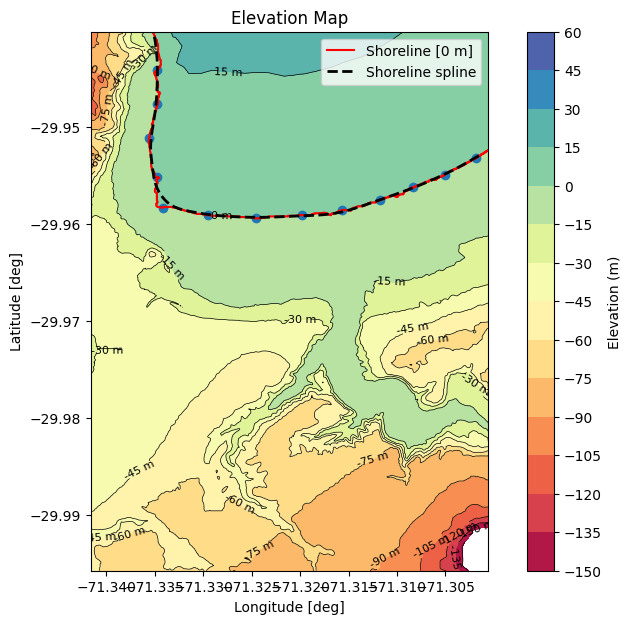

In [9]:
# Plot topobathy and shoreline
fig, ax = plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                           elev_min   = -150, 
                                           elev_max   = 60, 
                                           elev_delta = 15, 
                                           z0_contour = shoreline,
                                           cmap       = 'Spectral')
                                        

ax.plot(smoothed_points[:,0], smoothed_points[:,1], ls='--', lw=2, c='black', label='Shoreline spline')
x_equidistant, y_equidistant = equidistant_points_on_curve(shoreline[:,0], shoreline[:,1], distance=500)
ax.scatter(x_equidistant, y_equidistant)
ax.legend()
ax.set_aspect('equal')

### LOAD ORIGINAL TRANSECTS

In [10]:
## Dict to storage transects
transects_new = dict()

## Transect setup
extension_length   = 5000 
n_points_transect  = extension_length
distance           = 50
# Use average latitude for conversion to meters
avg_lat            = np.mean(smoothed_points[:, 1])

## Equidistant points on shoreline curve
x_equidistant, y_equidistant = equidistant_points_on_curve(shoreline[:,0], shoreline[:,1], distance)

## Perpendicular line at intersected point
## Units: meters UTM 
initial_points, end_points = perpendicular_line(x_equidistant, y_equidistant, smoothed_points, extension_length)

## Bathy interpolation
maps                   = [mesh_lon, mesh_lat, bathy]
interpolation_function = create_interpolation_function(maps)

## Interpolating each transect into bathy
for ix, (initial_point, end_point) in tqdm(enumerate(zip(initial_points, end_points)), total=len(initial_points)):

    ## Transect interpolation using bathy
    deltax_lon, deltay_lat, deltax, deltay, elevation = evaluate_transect(initial_point, end_point,
                                                  extension_length, n_points_transect, interpolation_function, avg_lat)

    ## Create dataframe for transect to storage
    df_transect_interp = pd.DataFrame(zip(deltax_lon, deltay_lat, deltax, deltay, elevation), columns=['lon','lat', 'x', 'y','Elevation'])
    ## Filter for elevation
    df_transect_interp = df_transect_interp[df_transect_interp['Elevation']<=50]

    ## Save new transect
    transects_new[f'T{str(ix+1).zfill(3)}'] = df_transect_interp

## Plot setup
fig, axs = plt.subplots(1,1, figsize=(12,10))

plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                 elev_min   = -90, 
                                 elev_max   = 240, 
                                 elev_delta = 30, 
                                 z0_contour = shoreline,
                                 cmap       = 'viridis',
                                 ax         = axs)


for line_start, line_end in zip(initial_points, end_points):

    # Convert lon/lat to meters
    lat_to_meters = 111000  # 111 km per degree
    lon_to_meters = 111000 * np.cos(np.radians(avg_lat))
    plt.plot([line_start[0] / lon_to_meters, line_end[0] / lon_to_meters],
             [line_start[1] / lat_to_meters, line_end[1] / lat_to_meters], 'r--')

#axs.set_aspect('equal', adjustable='box')
axs.set_xlim(grid_lon.min(), grid_lon.max())
axs.set_ylim(grid_lat.min(), grid_lat.max())
axs.legend()
ax.set_aspect('equal')
plt.show()

 38%|███▊      | 51/134 [06:32<10:38,  7.69s/it]


KeyboardInterrupt: 

### PLOT TRANSECTS

In [5]:
# Función para filtrar el dataframe de acuerdo a las reglas indicadas
def filtrar_elevaciones(df):
    # Filtrar por elevaciones menores o iguales a 30 metros
    df_filtrado = df[df['Elevation'] <= 30]
    
    # Si existen puntos que sobrepasan los 30 metros en algún momento
    if len(df_filtrado) < len(df):
        # Tomamos la primera aparición de un valor mayor a 30 y cortamos ahí
        primer_sobrepaso = df[df['Elevation'] > 30].index[0]
        df_filtrado = df.loc[:primer_sobrepaso - 1]  # Mantener los valores hasta antes de ese punto
    
    return df_filtrado

# Aplicamos la función a todos los dataframes del diccionario
transects_new2 = {nombre: filtrar_elevaciones(df) for nombre, df in transects_new.items()}

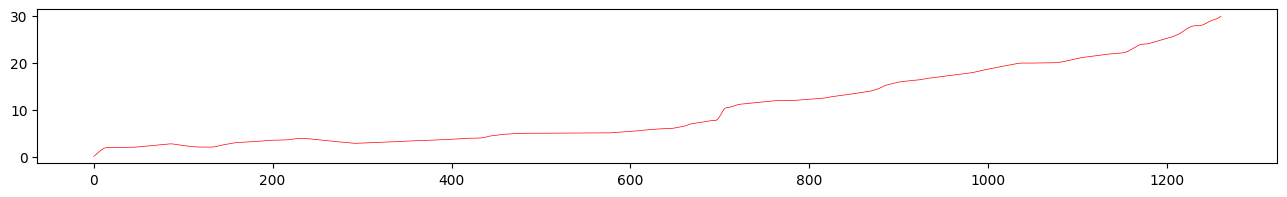

In [20]:
## PLOTING TRANSECTS ORGINAL AND NEW 

fig, ax = plt.subplots(1,1, figsize=(16,2), sharex=True)

for transec in ['T040']:#list(transects_new.keys())[::-1]:
    distance = np.sqrt((transects_new2[transec]['x']-transects_new2[transec]['x'].min())**2+(transects_new2[transec]['y']-transects_new2[transec]['y'].max())**2)
    elevation = transects_new2[transec]['Elevation']
    ax.plot(distance,elevation, c='red', lw=0.5)


/var/folders/59/6z9s6k7x6qx1snd2pdtz26680000gn/T/ipykernel_17807/3931204892.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


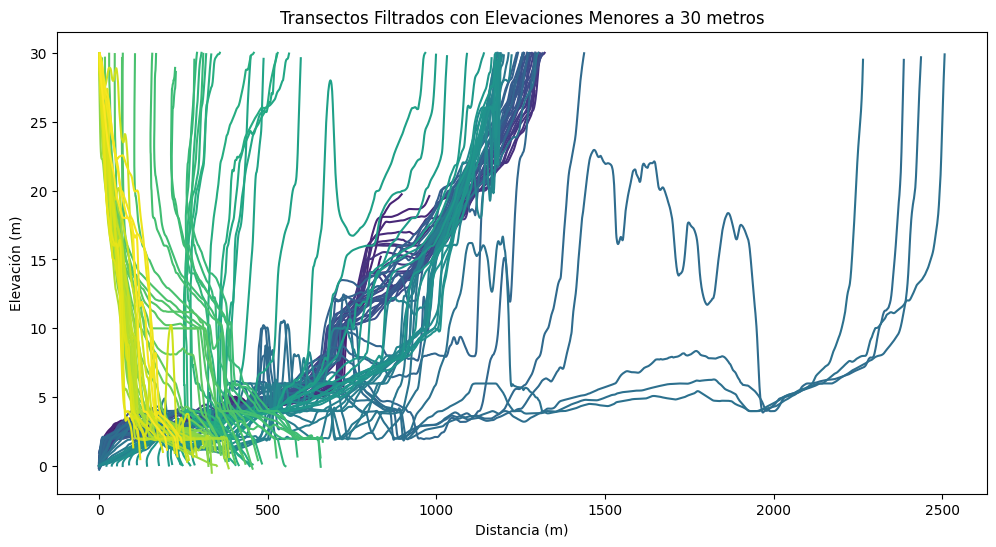

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# Preparar el gráfico
plt.figure(figsize=(12, 6))

# Escala de colores "viridis"
norm = Normalize(vmin=0, vmax=len(transects_new2))
cmap = cm.get_cmap('viridis')

# Graficar cada dataframe filtrado con un color diferente
for i, (nombre, df) in enumerate(transects_new2.items()):
    color = cmap(norm(i))  # Obtener el color correspondiente
    distance = np.sqrt((df['x']-df['x'].min())**2+(df['y']-df['y'].max())**2)
    plt.plot(distance, df['Elevation'], color=color, label=f'Transecto {i+1}')

# Etiquetas del gráfico
plt.title('Transectos Filtrados con Elevaciones Menores a 30 metros')
plt.xlabel('Distancia (m)')
plt.ylabel('Elevación (m)')
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Número de Transecto')

# Mostrar el gráfico
plt.show()


In [ ]:
slopes = []
for ix, df in transects_new.items():
    maxelev = df['Elevation'][:50].max()
    slopes.append(maxelev/50)

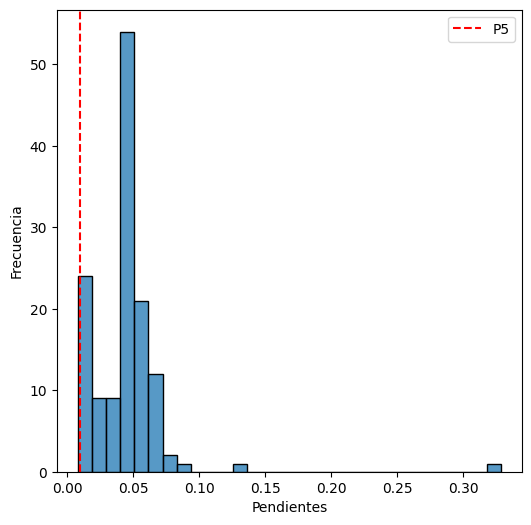

In [ ]:
import seaborn as sns

# Calcular los percentiles 5, 50 y 95
p5 = np.percentile(slopes, 5)
p50 = np.percentile(slopes, 50)
p95 = np.percentile(slopes, 95)

# Crear el histograma usando seaborn
plt.figure(figsize=(6, 6))
sns.histplot(slopes, bins=30, kde=False, edgecolor='black')


# Dibujar líneas para los percentiles
plt.axvline(1/100, color='red', linestyle='dashed', linewidth=1.5, label='P5')
#plt.axvline(p50, color='red', linestyle='-', linewidth=1.5, label='P50')
#plt.axvline(p95, color='red', linestyle='dashed', linewidth=1.5, label='P95')

# Etiquetas y título
plt.xlabel('Pendientes')
plt.ylabel('Frecuencia')
#plt.title('Histograma de Pendientes con Percentiles 5, 50 y 95')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

### SAVE TRANSECTS AS NC FILE

In [38]:
# Guardar el diccionario en un archivo HDF5
with pd.HDFStore('../Data/Coquimbo/Transects_N134_LonLat.h5') as store:
    for key, df in transects_new2.items():
        store[key] = df

In [39]:
np.save('../Data/Coquimbo/Shoreline_points_LonLat.npy', shoreline)

# VIÑA DEL MAR

### LOAD AND PLOT TOPOBATHY

In [4]:
## Load bathy
## Get spatial data from asc file
grid_lon, grid_lat, bathy = load_asc_file('../Data/Vina/Mapa_Vina.asc')
grid_lon = grid_lon[0,:] ## To obtain only the vector of longitudes
grid_lat = grid_lat[:,0] ## To obtain only the vector of latitudes

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)

## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 50, reduction_factor=40, smooth_window=20)

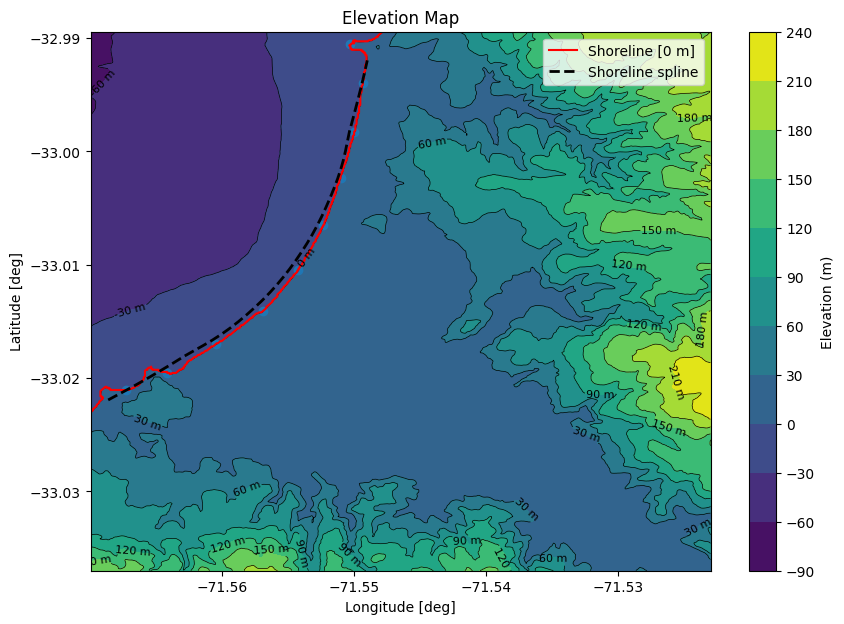

In [5]:
# Plot topobathy and shoreline
fig, ax = plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                           elev_min   = -90, 
                                           elev_max   = 240, 
                                           elev_delta = 30, 
                                           z0_contour = shoreline,
                                           cmap       = 'viridis')
                                        

ax.plot(smoothed_points[:,0], smoothed_points[:,1], ls='--', lw=2, c='black', label='Shoreline spline')
x_equidistant, y_equidistant = equidistant_points_on_curve(shoreline[:,0], shoreline[:,1], distance=500)
ax.scatter(x_equidistant, y_equidistant)
ax.legend()

## LOAD ORIGINAL TRANSECTS

100%|██████████| 106/106 [07:04<00:00,  4.01s/it]


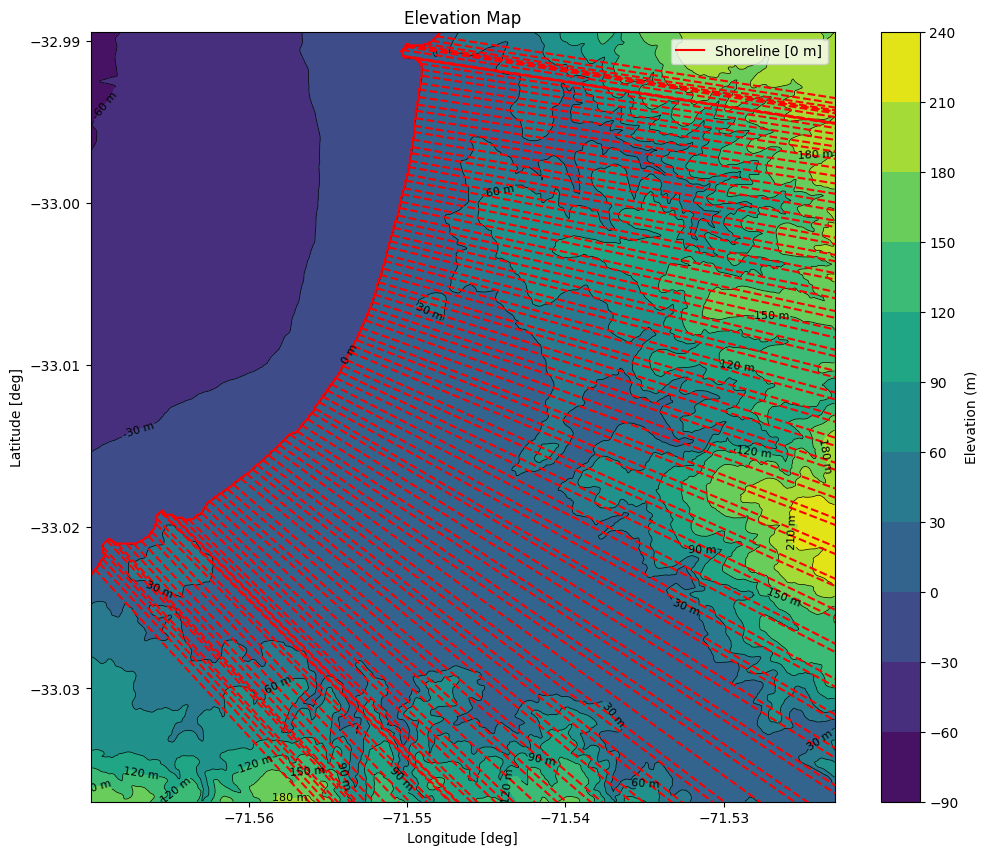

In [6]:
## Dict to storage transects
transects_new = dict()

## Transect setup
extension_length   = 5000 
n_points_transect  = extension_length
distance           = 50
# Use average latitude for conversion to meters
avg_lat            = np.mean(smoothed_points[:, 1])

## Equidistant points on shoreline curve
x_equidistant, y_equidistant = equidistant_points_on_curve(shoreline[:,0], shoreline[:,1], distance)

## Perpendicular line at intersected point
## Units: meters UTM 
initial_points, end_points = perpendicular_line(x_equidistant, y_equidistant, smoothed_points, extension_length)

## Bathy interpolation
maps                   = [mesh_lon, mesh_lat, bathy]
interpolation_function = create_interpolation_function(maps)

## Interpolating each transect into bathy
for ix, (initial_point, end_point) in tqdm(enumerate(zip(initial_points, end_points)), total=len(initial_points)):

    ## Transect interpolation using bathy
    deltax_lon, deltay_lat, deltax, deltay, elevation = evaluate_transect(initial_point, end_point,
                                                  extension_length, n_points_transect, interpolation_function, avg_lat)

    ## Create dataframe for transect to storage
    df_transect_interp = pd.DataFrame(zip(deltax_lon, deltay_lat, deltax, deltay, elevation), columns=['lon','lat', 'x', 'y','Elevation'])
    ## Filter for elevation
    df_transect_interp = df_transect_interp[df_transect_interp['Elevation']<=50]

    ## Save new transect
    transects_new[f'T{str(ix+1).zfill(3)}'] = df_transect_interp

## Plot setup
fig, axs = plt.subplots(1,1, figsize=(12,10))

plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                 elev_min   = -90, 
                                 elev_max   = 240, 
                                 elev_delta = 30, 
                                 z0_contour = shoreline,
                                 cmap       = 'viridis',
                                 ax         = axs)


for line_start, line_end in zip(initial_points, end_points):
    
    

    # Convert lon/lat to meters
    lat_to_meters = 111000  # 111 km per degree
    lon_to_meters = 111000 * np.cos(np.radians(avg_lat))
    plt.plot([line_start[0] / lon_to_meters, line_end[0] / lon_to_meters],
             [line_start[1] / lat_to_meters, line_end[1] / lat_to_meters], 'r--')

#axs.set_aspect('equal', adjustable='box')
axs.set_xlim(grid_lon.min(), grid_lon.max())
axs.set_ylim(grid_lat.min(), grid_lat.max())
axs.legend()
plt.show()

### PLOT TRANSECTS

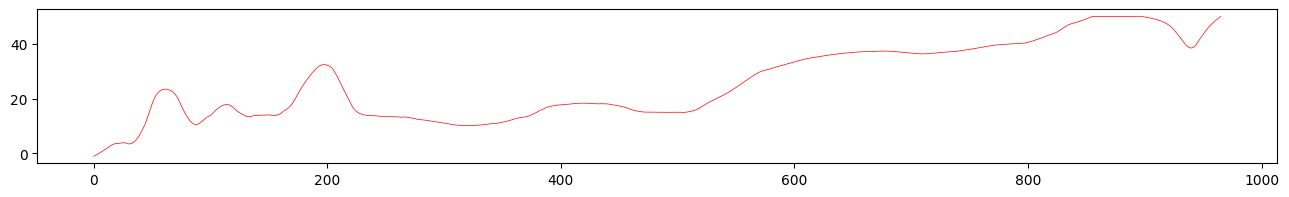

In [10]:
## PLOTING TRANSECTS ORGINAL AND NEW 

fig, ax = plt.subplots(1,1, figsize=(16,2), sharex=True)

for transec in ['T100']:#list(transects_new.keys())[::-1]:
    distance = np.sqrt((transects_new[transec]['x']-transects_new[transec]['x'].min())**2+(transects_new[transec]['y']-transects_new[transec]['y'].max())**2)
    elevation = transects_new[transec]['Elevation']
    ax.plot(distance,elevation, c='red', lw=0.5)


### SAVE TRANSECTS AS NC FILE

In [12]:
# Guardar el diccionario en un archivo HDF5
with pd.HDFStore('../Data/Vina/Transects_N106_LonLat.h5') as store:
    for key, df in transects_new.items():
        store[key] = df

In [13]:
np.save('../Data/Vina/Shoreline_points_LonLat.npy', shoreline)

# VALPARAISO

### LOAD AND PLOT TOPOBATHY

In [215]:
## Load bathy
## Get spatial data from asc file
grid_lon, grid_lat, bathy = load_asc_file('./Data/Mapa_Valparaiso.asc')
grid_lon = grid_lon[0,:] ## To obtain only the vector of longitudes
grid_lat = grid_lat[:,0] ## To obtain only the vector of latitudes

## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)
shoreline = np.concatenate([shoreline[:70], shoreline[340:490], #shoreline[520:537],
                            shoreline[570:815], shoreline[870:]], axis=0)
## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 120, reduction_factor=10, smooth_window=10)

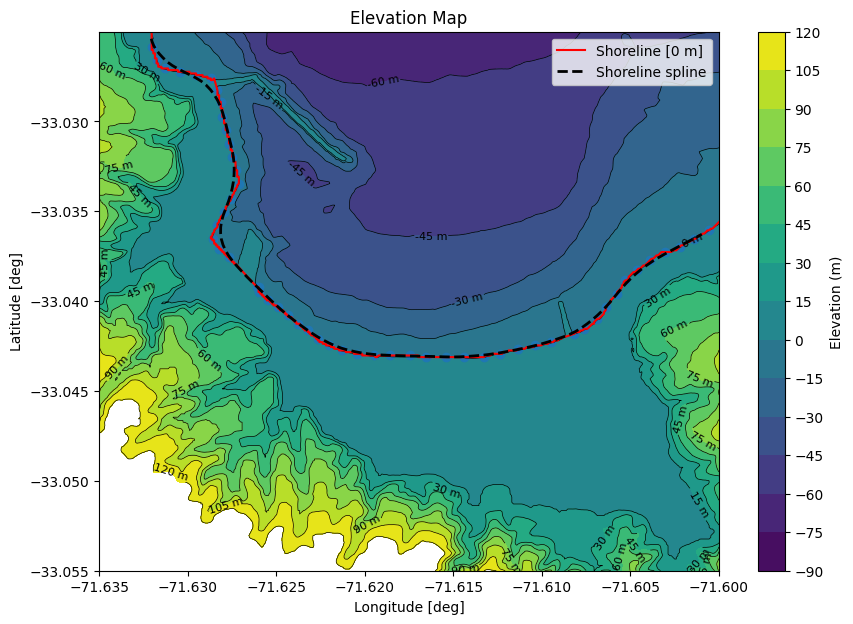

In [216]:
# Plot topobathy and shoreline
fig, ax = plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                           elev_min   = -90, 
                                           elev_max   = 120, 
                                           elev_delta = 15, 
                                           z0_contour = shoreline,
                                           cmap       = 'viridis')
                                        

ax.plot(smoothed_points[:,0], smoothed_points[:,1], ls='--', lw=2, c='black', label='Shoreline spline')
x_equidistant, y_equidistant = equidistant_points_on_curve(shoreline[:,0], shoreline[:,1], distance=100)
ax.scatter(x_equidistant, y_equidistant)
ax.legend()

## LOAD ORIGINAL TRANSECTS

100%|██████████| 118/118 [02:23<00:00,  1.21s/it]


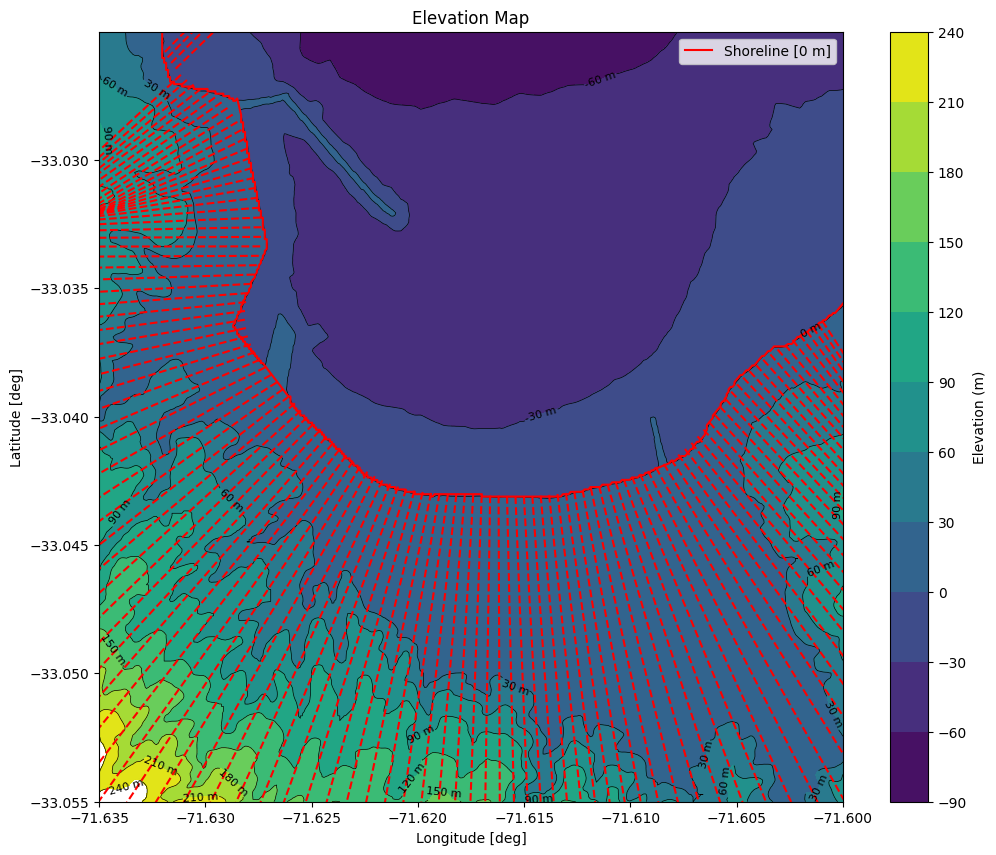

In [217]:
## Dict to storage transects
transects_new = dict()

## Transect setup
extension_length   = 5000 
n_points_transect  = extension_length
distance           = 30
# Use average latitude for conversion to meters
avg_lat            = np.mean(smoothed_points[:, 1])

## Equidistant points on shoreline curve
x_equidistant, y_equidistant = equidistant_points_on_curve(smoothed_points[:,0], smoothed_points[:,1], distance)

## Perpendicular line at intersected point
## Units: meters UTM 
initial_points, end_points = perpendicular_line(x_equidistant, y_equidistant, smoothed_points, extension_length)

## Bathy interpolation
maps                   = [mesh_lon, mesh_lat, bathy]
interpolation_function = create_interpolation_function(maps)

## Interpolating each transect into bathy
for ix, (initial_point, end_point) in tqdm(enumerate(zip(initial_points, end_points)), total=len(initial_points)):

    ## Transect interpolation using bathy
    deltax_lon, deltay_lat, deltax, deltay, elevation = evaluate_transect(initial_point, end_point,
                                                  extension_length, n_points_transect, interpolation_function, avg_lat)

    ## Create dataframe for transect to storage
    df_transect_interp = pd.DataFrame(zip(deltax_lon, deltay_lat, deltax, deltay, elevation), columns=['lon','lat', 'x', 'y','Elevation'])
    ## Filter for elevation
    df_transect_interp = df_transect_interp[df_transect_interp['Elevation']<=50]

    ## Save new transect
    transects_new[f'T{str(ix+1).zfill(3)}'] = df_transect_interp

## Plot setup
fig, axs = plt.subplots(1,1, figsize=(12,10))

plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                 elev_min   = -90, 
                                 elev_max   = 240, 
                                 elev_delta = 30, 
                                 z0_contour = shoreline,
                                 cmap       = 'viridis',
                                 ax         = axs)


for line_start, line_end in zip(initial_points, end_points):
    
    

    # Convert lon/lat to meters
    lat_to_meters = 111000  # 111 km per degree
    lon_to_meters = 111000 * np.cos(np.radians(avg_lat))
    plt.plot([line_start[0] / lon_to_meters, line_end[0] / lon_to_meters],
             [line_start[1] / lat_to_meters, line_end[1] / lat_to_meters], 'r--')

#axs.set_aspect('equal', adjustable='box')
axs.set_xlim(grid_lon.min(), grid_lon.max())
axs.set_ylim(grid_lat.min(), grid_lat.max())
axs.legend()
plt.show()

### PLOT TRANSECTS

In [218]:
# Eliminar los primeros 5 dataframes y renombrar las claves restantes
transects_new = {f'T{i+1:03d}': df for i, (key, df) in enumerate(transects_new.items()) if i >= 5}

In [219]:
# Crear una nueva versión del diccionario con claves renombradas
transects_new2 = {}
for i, key in enumerate(sorted(transects_new.keys()), start=1):
    new_key = f'T{i:03d}'  # Formatear la nueva clave como 'T001', 'T002', etc.
    transects_new2[new_key] = transects_new[key]

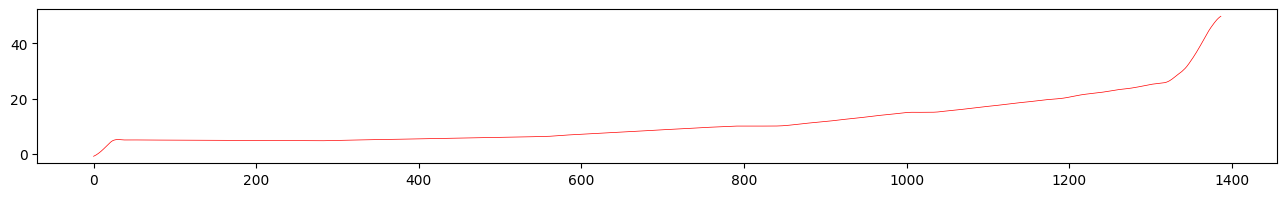

In [210]:
## PLOTING TRANSECTS ORGINAL AND NEW 

fig, ax = plt.subplots(1,1, figsize=(16,2), sharex=True)

for transec in ['T080']:#list(transects_new.keys())[::-1]:
    distance = np.sqrt((transects_new2[transec]['x']-transects_new2[transec]['x'].min())**2+(transects_new2[transec]['y']-transects_new2[transec]['y'].max())**2)
    elevation = transects_new2[transec]['Elevation']
    ax.plot(distance,elevation, c='red', lw=0.5)


### SAVE TRANSECTS AS NC FILE

In [221]:
save_transects_to_netcdf(transects_new2, 'Valparaiso_transects_N113_LonLat.nc')

In [222]:
np.save('./Processed/Valparaiso_shoreline_points_LonLat.npy', shoreline)

In [ ]:
# load transects
transects_loaded = load_transects_from_netcdf('./Processed/Coq_transects_N134_LonLat.nc')

# CARTAGENA

### LOAD AND PLOT TOPOBATHY

In [14]:
## Load bathy
## Get spatial data from asc file
grid_lon, grid_lat, bathy = load_asc_file('../Data/Cartagena/Mapa_Cartagena.asc')
grid_lon = grid_lon[0,:] ## To obtain only the vector of longitudes
grid_lat = grid_lat[:,0] ## To obtain only the vector of latitudes

## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)
## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 100, reduction_factor=40, smooth_window=10)

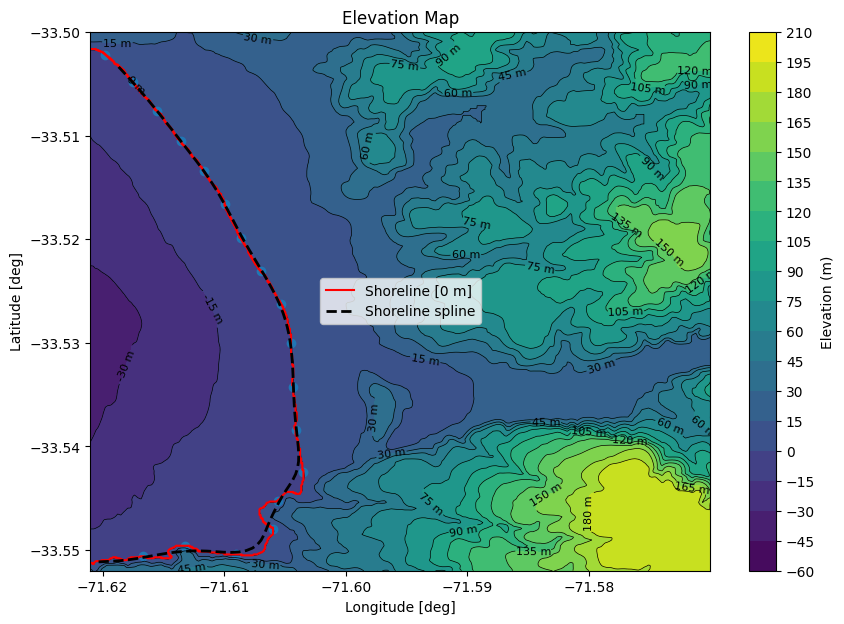

In [15]:
# Plot topobathy and shoreline
fig, ax = plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                           elev_min   = -60, 
                                           elev_max   = 210, 
                                           elev_delta = 15, 
                                           z0_contour = shoreline,
                                           cmap       = 'viridis')
                                        

ax.plot(smoothed_points[:,0], smoothed_points[:,1], ls='--', lw=2, c='black', label='Shoreline spline')
x_equidistant, y_equidistant = equidistant_points_on_curve(shoreline[:,0], shoreline[:,1], distance=500)
ax.scatter(x_equidistant, y_equidistant)
ax.legend()

## LOAD ORIGINAL TRANSECTS

100%|██████████| 183/183 [23:12<00:00,  7.61s/it] 


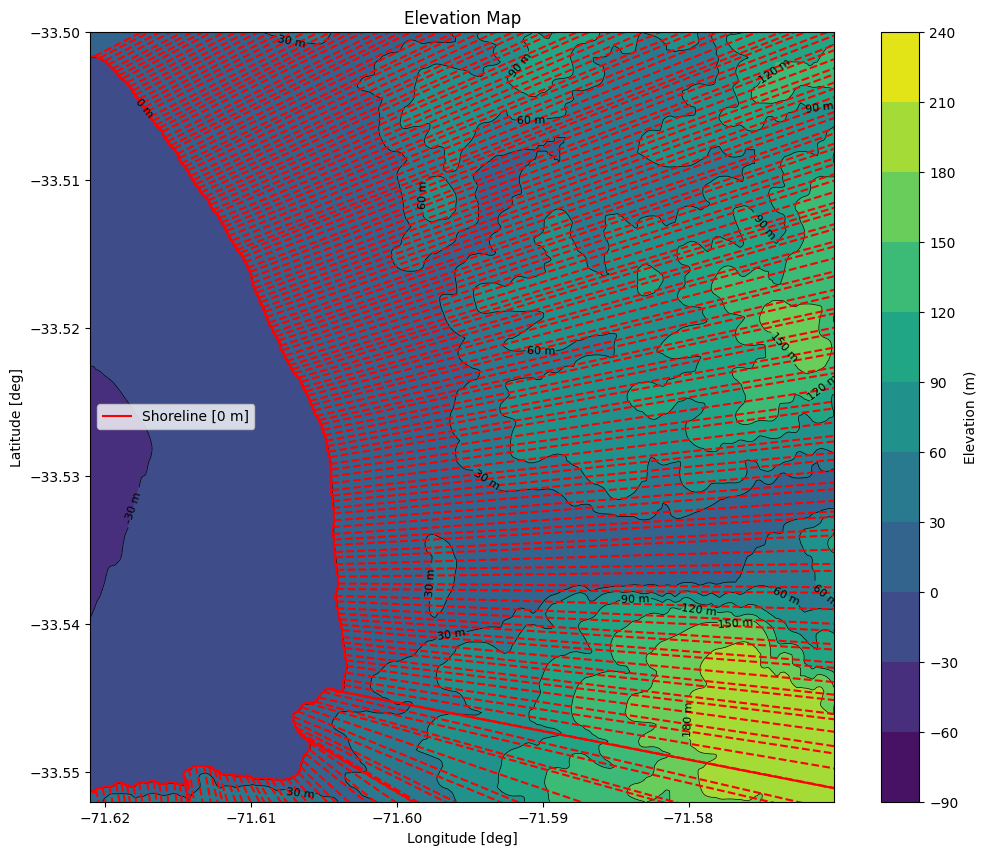

In [16]:
## Dict to storage transects
transects_new = dict()

## Transect setup
extension_length   = 5000 
n_points_transect  = extension_length
distance           = 50
# Use average latitude for conversion to meters
avg_lat            = np.mean(smoothed_points[:, 1])

## Equidistant points on shoreline curve
x_equidistant, y_equidistant = equidistant_points_on_curve(shoreline[:,0], shoreline[:,1], distance)

## Perpendicular line at intersected point
## Units: meters UTM 
initial_points, end_points = perpendicular_line(x_equidistant, y_equidistant, smoothed_points, extension_length)

## Bathy interpolation
maps                   = [mesh_lon, mesh_lat, bathy]
interpolation_function = create_interpolation_function(maps)

## Interpolating each transect into bathy
for ix, (initial_point, end_point) in tqdm(enumerate(zip(initial_points, end_points)), total=len(initial_points)):

    ## Transect interpolation using bathy
    deltax_lon, deltay_lat, deltax, deltay, elevation = evaluate_transect(initial_point, end_point,
                                                  extension_length, n_points_transect, interpolation_function, avg_lat)

    ## Create dataframe for transect to storage
    df_transect_interp = pd.DataFrame(zip(deltax_lon, deltay_lat, deltax, deltay, elevation), columns=['lon','lat', 'x', 'y','Elevation'])
    ## Filter for elevation
    df_transect_interp = df_transect_interp[df_transect_interp['Elevation']<=50]

    ## Save new transect
    transects_new[f'T{str(ix+1).zfill(3)}'] = df_transect_interp

## Plot setup
fig, axs = plt.subplots(1,1, figsize=(12,10))

plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                 elev_min   = -90, 
                                 elev_max   = 240, 
                                 elev_delta = 30, 
                                 z0_contour = shoreline,
                                 cmap       = 'viridis',
                                 ax         = axs)


for line_start, line_end in zip(initial_points, end_points):
    
    

    # Convert lon/lat to meters
    lat_to_meters = 111000  # 111 km per degree
    lon_to_meters = 111000 * np.cos(np.radians(avg_lat))
    plt.plot([line_start[0] / lon_to_meters, line_end[0] / lon_to_meters],
             [line_start[1] / lat_to_meters, line_end[1] / lat_to_meters], 'r--')

#axs.set_aspect('equal', adjustable='box')
axs.set_xlim(grid_lon.min(), grid_lon.max())
axs.set_ylim(grid_lat.min(), grid_lat.max())
axs.legend()
plt.show()

### PLOT TRANSECTS

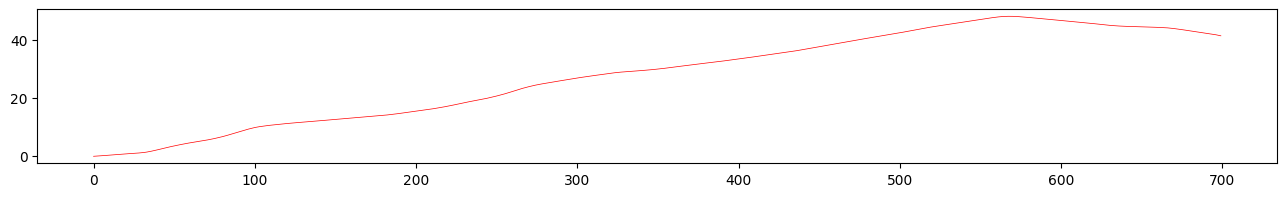

In [17]:
## PLOTING TRANSECTS ORGINAL AND NEW 

fig, ax = plt.subplots(1,1, figsize=(16,2), sharex=True)

for transec in ['T040']:#list(transects_new.keys())[::-1]:
    distance = np.sqrt((transects_new[transec]['x']-transects_new[transec]['x'].min())**2+(transects_new[transec]['y']-transects_new[transec]['y'].max())**2)
    elevation = transects_new[transec]['Elevation']
    ax.plot(distance,elevation, c='red', lw=0.5)


### SAVE TRANSECTS

In [18]:
# Guardar el diccionario en un archivo HDF5
with pd.HDFStore('../Data/Cartagena/Transects_N183_LonLat.h5') as store:
    for key, df in transects_new.items():
        store[key] = df

In [19]:
np.save('../Data/Cartagena/Shoreline_points_LonLat.npy', shoreline)